# <font color='blue'>ISAT 449 - Emerging Topics in Applied Data Science</font>
## <font color='green'>EuroSAT Classification Project</font>
## <font color='orange'>Author: Blake Jones</font>

### The EuroSAT Dataset
EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting of 10 classes with 27000 labeled and geo-referenced samples. The different classes are:

* Residential
* Highway
* HerbaceousVegetation
* PermanentCrop
* SeaLake
* River
* Pasture
* Forest
* AnnualCrop
* Industrial

### Goal

We want to determine climate change through satellite imagery using two novel satellite imagery datasets. Eurosat and Spacenet 7.

Ideally, we will use the EuroSAT dataset to build and train the model, and we will pass image subsets of Spacenet 7 to our model we built using Eurosat to classify them. We will then compare the classifications of the timeseries images and determine change.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing
print("TensorFlow Version: ", tf.__version__)
print("Num GPUs Available", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version:  2.7.0
Num GPUs Available 1


### Load the dataset

In [ ]:
images, labels = tfds.as_numpy(tfds.load(
    'eurosat',
    split='train',
    batch_size=-1,
    as_supervised=True,
))
train_images, test_images = images[:20250], images[20250:]
train_labels, test_labels = labels[:20250], labels[20250:]


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteQX3REB/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


### Create a python list of the class names

In [ ]:
class_names = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'Sea Lake']

## Display shape of the training and testing data

In [ ]:
print('Shape of training images: {}'.format(train_images.shape))
print('Shape of training labels: {}'.format(train_labels.shape))
print('Shape of testing images: {}'.format(test_images.shape))
print('Shape of testing labels: {}'.format(test_labels.shape))

Shape of training images: (20250, 64, 64, 3)
Shape of training labels: (20250,)
Shape of testing images: (6750, 64, 64, 3)
Shape of testing labels: (6750,)


### Display some images using matplotlib

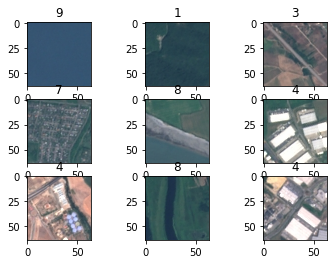

In [ ]:
import matplotlib.pyplot as plt
for i in range(9):
    # define subplot
    plt.subplot(3,  3, i+1)
    # plot raw image pixel data
    plt.title(train_labels[i])
    plt.imshow(train_images[i])
# show the images
plt.show()

## Normalize the images

In [ ]:
train_images=train_images/255.0
test_images=test_images/255.0

## Print the bincount

In [ ]:
train_bins = np.bincount(train_labels)
print(train_bins)
test_bins = np.bincount(test_labels)
print(test_bins)

[2253 2241 2219 1873 1874 1539 1878 2262 1877 2234]
[747 759 781 627 626 461 622 738 623 766]


## Build the Model

We want a model that will provide an accuracy of greater than 90%, there are many model constructions that will provide this accuracy. This just so happens to be the model that we decided on.

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer((64,64,3)),

  preprocessing.RandomRotation(factor=0.35),

  tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),
                         activation='relu', padding='same'),
  
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),

  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'),

  tf.keras.layers.Dropout(0.05),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),

  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same'),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(512, activation='relu'),

  tf.keras.layers.Dropout(0.15),

  tf.keras.layers.Dense(128, activation='relu'),

  tf.keras.layers.Dropout(0.05),

  tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
optimize=tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimize,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 64, 64, 3)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                        

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.01)

# We never reduce the lr on plateau, this callback is not used.

EPOCHS = 75
history = model.fit(
    train_images, train_labels,
    batch_size=16, epochs=EPOCHS, validation_split=0.1, verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/75
1140/1140 [==============================] - 19s 9ms/step - loss: 1.3246 - accuracy: 0.5011 - val_loss: 1.1152 - val_accuracy: 0.6099 - lr: 1.0000e-04
Epoch 2/75
1140/1140 [==============================] - 10s 9ms/step - loss: 0.9094 - accuracy: 0.6719 - val_loss: 0.7742 - val_accuracy: 0.7348 - lr: 1.0000e-04
Epoch 3/75
1140/1140 [==============================] - 11s 9ms/step - loss: 0.7289 - accuracy: 0.7394 - val_loss: 1.1933 - val_accuracy: 0.6143 - lr: 1.0000e-04
Epoch 4/75
1140/1140 [==============================] - 11s 10ms/step - loss: 0.6537 - accuracy: 0.7693 - val_loss: 0.5736 - val_accuracy: 0.8040 - lr: 1.0000e-04
Epoch 5/75
1140/1140 [==============================] - 11s 9ms/step - loss: 0.6062 - accuracy: 0.7813 - val_loss: 0.7107 - val_accuracy: 0.7501 - lr: 1.0000e-04
Epoch 6/75
1140/1140 [==============================] - 11s 10ms/step - loss: 0.5763 - accuracy: 0.7948 - val_loss: 0.6831 - val_accuracy: 0.7491 - lr: 1.0000e-04
Epoch 7/75
1140/1140 [====

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels,verbose=1)
print('The test set loss is: {0:0.4f} and the test set accuracy is: {1:0.4}%'.format(test_loss, 100*test_acc))

211/211 [==============================] - 1s 5ms/step - loss: 0.2011 - accuracy: 0.9347
The test set loss is: 0.2011 and the test set accuracy is: 93.47%


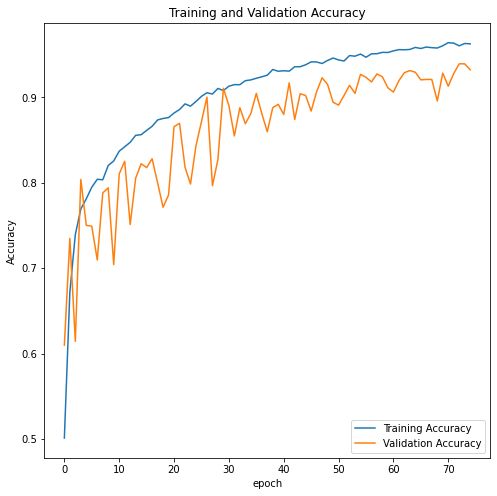

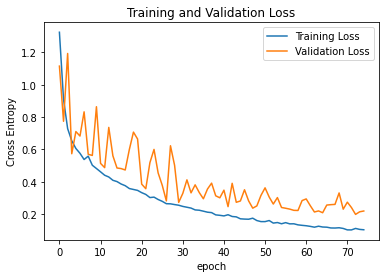

In [ ]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8,8))
plt.subplot=(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

plt.subplot=(2, 1 , 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Spacenet Data

Now, we will move onto the Spacenet 7 dataset, from here we will use the model we built on the Eurosat data to classify tile-ized images. 

###What are tile-ized images?

Image tiles are images that are separated from a larger image into smaller images. Below is an example of how images are separated

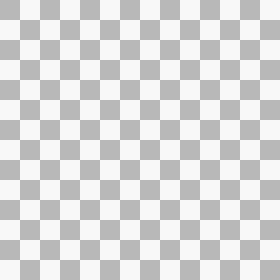

**Plan**
1. Download and extract Spacenet 7 dataset.
2. Generate code to breakdown large images into smaller images without any rescaling or reduction to image features.
3. Breakdown time-series images into tiles.
4. Take the tiles and classify them using the Eurosat model.
5. Generate a bar plot to determine change over time.



## Download awscli and the Spacenet bucket

In [ ]:
!pip install awscli
!aws s3 cp s3://spacenet-dataset/spacenet/SN7_buildings/tarballs/SN7_buildings_train.tar.gz . --no-sign-request

     |████████████████████████████████| 3.8 MB 8.2 MB/s 
     |████████████████████████████████| 8.4 MB 61.3 MB/s 
     |████████████████████████████████| 79 kB 10.3 MB/s 
     |████████████████████████████████| 547 kB 62.7 MB/s 
     |████████████████████████████████| 138 kB 70.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: rsa
    Found existing installation: rsa 4.8
    Uninstalling rsa-4.8:
      Successfully uninstalled rsa-4.8
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
      Successfully uninstalled docutils-0.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have ur

download: s3://spacenet-dataset/spacenet/SN7_buildings/tarballs/SN7_buildings_train.tar.gz to ./SN7_buildings_train.tar.gz


In [ ]:
import tarfile
file = tarfile.open('SN7_buildings_train.tar.gz', mode='r')

In [ ]:
file.extractall()

## Tile-ize the data and first data cube classification

The tile-ization code is built to concatenate the x as the i and the y as the j to the file path. See the inline code for more information. At this point, we know that there can be some images with extra concatenations on the end of the filepath if ran multiple times.

In [ ]:
import matplotlib.pyplot as plt
import os
from itertools import product
from PIL import Image


# This tile method takes in a filename, a directory input, a directory output, and the amount of pixels wanted from the main image.
def tile(filename, dir_in, dir_out, d):
    # grab the file name and the file extension.
    name, ext = os.path.splitext(filename)
    print(os.path.join(dir_in, filename))
    # open the image.
    img = Image.open(os.path.join(dir_in, filename))
    # grab the image sizes.
    w, h = img.size
    
    # using itertools product, grab the grid max
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    # for each i and j in the grid, grab the box of that grid (the smaller portion of the image) and create a new cropped image with those dimensions.
    for i, j in grid:
        box = (j, i, j+d, i+d)
        # concatenate the i and j (x and y) of the top left of the image to the file path.
        out = os.path.join(dir_out, f'{name}_{i}_{j}{ext}')
        # save the cropped image to the out directory.
        img.crop(box).save(out)


# grab the file names and the directory currently in.
file_names = os.listdir('./train')
directory = './train/' + str(file_names[0]) + '/images'

# for every image (since we want to put all the sub images, tiles, in the same directory as the original images).
# select the image path, join it to the directory path, then generate (64,64) tiles for every image in that directory.
for image in os.listdir(directory):
  path = str(image)
  relative = os.path.join(directory,path)
  print(relative)
  #tile(path, directory, directory, 64)


Streaming output truncated to the last 5000 lines.
./train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_09_mosaic_L15-1748E-1247N_6993_3202_13_0_256.tif
./train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_06_mosaic_L15-1748E-1247N_6993_3202_13_704_320.tif
./train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_04_mosaic_L15-1748E-1247N_6993_3202_13_960_384.tif
./train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_07_mosaic_L15-1748E-1247N_6993_3202_13_704_448.tif
./train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2019_11_mosaic_L15-1748E-1247N_6993_3202_13_448_320.tif
./train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_08_mosaic_L15-1748E-1247N_6993_3202_13_128_768.tif
./train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_01_mosaic_L15-1748E-1247N_6993_3202_13_768_384.tif
./train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_08_mosaic_L15-1748E-1247N_6993_3202_13_192_896.tif
./train/L15-1748E-1247N_6993_32

Here, we are grabbing three separate time-series images from the same area, and classifying them using eurosat and appending those classifications to their respective arrays.

In [ ]:
import cv2
from numpy import asarray

# create three new data arrays for the classifications.
data_arr_2018 = []           
data_arr_2019 = []
data_arr_2020 = []

# two initialized arrays with the path of the images we want to classify, with the .tif extensions removed.
permanent_arr = ['/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_01_mosaic_L15-1748E-1247N_6993_3202_13', '/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2019_01_mosaic_L15-1748E-1247N_6993_3202_13', '/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2020_01_mosaic_L15-1748E-1247N_6993_3202_13']
splice_arr = ['/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_01_mosaic_L15-1748E-1247N_6993_3202_13', '/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2019_01_mosaic_L15-1748E-1247N_6993_3202_13', '/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2020_01_mosaic_L15-1748E-1247N_6993_3202_13']

# for every image in the permanent array (3)
for k in range (0, len(permanent_arr)):
  # create a new temporary string equal the splice array index element. 
  temp_splice = splice_arr[k]
  # since we broke our images down into 64 x 64, we want to iterate through all instances of the images we broke down.
  for i in range (0, 1024, 64):
    for j in range (0, 1024, 64):
      # we need a double for loop for this operation, because we are classifying ONE image at a time.
      # we want to start with the first row of the sub images and then continue through each subsequent row.
      # once we open and predict those images, we will place their classification, IN THE SAME ORDER, into their respective arrays.
      # after we finish with all the classification of one image, we move onto the next image in the array.
      temp_splice = permanent_arr[k] + "_" + str(i) + "_" + str(j) + ".tif"
      # open the image and convert it to RGB
      image_RGBA = Image.open(temp_splice)
      image_fix = image_RGBA.convert('RGB')
      # use the numpy function to convert it into an array.
      data = asarray(image_fix)
      # predict that specific tile using our previously built model and grab the maximum (most probable) label in the numpy array returned.
      max = np.argmax(model.predict(data.reshape((1, 64, 64, 3)), verbose=1))
      # add it to its respective array.
      if ("2018_01" in temp_splice):
        data_arr_2018.append(class_names[max])
      elif ("2019_01" in temp_splice):
        data_arr_2019.append(class_names[max])
      elif("2020_01" in temp_splice):
        data_arr_2020.append(class_names[max])
      temp_splice = permanent_arr[k]


# print each array.
print(data_arr_2018)
print(data_arr_2019)
print(data_arr_2020)
    

1/1 [==============================] - 0s 19ms/step
['Industrial', 'Industrial', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Annual Crop', 'Permanent Crop', 'Annual Crop', 'Permanent Crop', 'Permanent Crop', 'Annual Crop', 'Permanent Crop', 'Permanent Crop', 'Industrial', 'Industrial', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Annual Crop', 'Annual Crop', 'Annual Crop', 'Annual Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Industrial', 'Annual Crop', 'Industrial', 'Annual Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Annual Crop', 'Permanent Crop', 'Permanent Crop', 'Annual Crop', 'Permanent Crop', 'Annual Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop', 'Permanent Crop',

## Analysis

Here we show change over time and change in classification. Below is a bar plot of the three separate years of classification. Also, the change in the classifications from the 3 years. 

We use 256 for the for loops because we are chopping a **1024 pixel x 1024 pixel** RGB image into **16 x 16 tiles of 64 x 64 pixels each** totaling back to <u>256 individual images</u>

In [ ]:
change_2018_2019 = 0
change_2019_2020 = 0

# change in classification from 2018 tiles to 2019 tiles.
for m in range (256):
  if data_arr_2018[m] != data_arr_2019[m]:
    change_2018_2019 = change_2018_2019 + 1

# change in classification from 2019 tiles to 2020 tiles.
for l in range (256):
  if data_arr_2019[l] != data_arr_2020[l]:
    change_2019_2020 = change_2019_2020 + 1


print("Change in classifications from 2018-2019: " + str(change_2018_2019))
print("Change in classifications from 2019-2020: "+ str(change_2019_2020))

Change in classifications from 2018-2019: 67
Change in classifications from 2019-2020: 61


##Bar chart

This bar plot shows the classifications for each data array which correspond to the three time-series images in ascending order

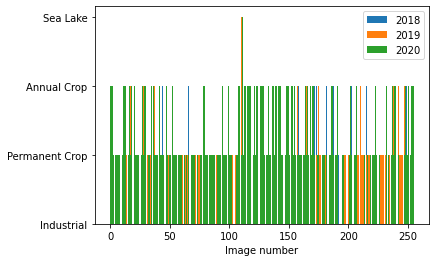

In [ ]:
plt.bar(np.arange(len(data_arr_2018)),data_arr_2018)
plt.bar(np.arange(len(data_arr_2019)),data_arr_2019)
plt.bar(np.arange(len(data_arr_2020)),data_arr_2020)

plt.xlabel('Image number')

plt.legend(['2018', '2019', '2020'], loc='best')

Lastly, these are the three images we downloaded from the dataset and shown here. It is hard with the human eye to tell differences, but the model can easily detect changes in pixels.

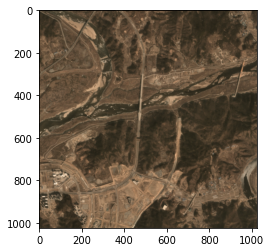

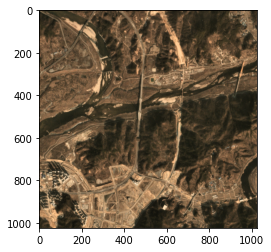

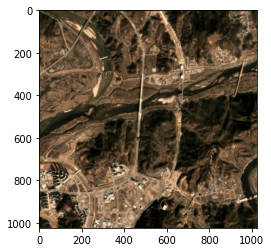

In [ ]:
import matplotlib.image as mpimg


img_2018 = mpimg.imread('/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2018_01_mosaic_L15-1748E-1247N_6993_3202_13.tif')
plt.imshow(img_2018)
plt.show()

img_2019 = mpimg.imread('/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2019_01_mosaic_L15-1748E-1247N_6993_3202_13.tif')
plt.imshow(img_2019)
plt.show()

img_2020 = mpimg.imread('/content/train/L15-1748E-1247N_6993_3202_13/images/global_monthly_2020_01_mosaic_L15-1748E-1247N_6993_3202_13.tif')
plt.imshow(img_2020)

## Summary

In conclusion, we explored in this notebook that it is possible to use the EuroSAT and Spacenet 7 datasets to determine change in satellite imagery. In the future, we hope to apply this to more imagery and integrate more spectral bands.